# Tutorial 6 - Physics-Informed Kolmogorov–Arnold Networks

One of the areas where KANs have found a lot of applications is PDE solving by replacing MLPs as the underlying architecture within the Physics-Informed Machine Learning (PIML) framework. This is why `jaxKAN` includes its own `pikan` module with several utilities relevant to Physics-Informed Kolmogorov–Arnold Networks (PIKANs), as this framework has come to be known.

In [1]:
from jaxkan.models.KAN import KAN

import jax
import jax.numpy as jnp

from jaxkan.pikan.pde import get_burgers_res
from jaxkan.pikan.sampling import get_collocs_sobol

from flax import nnx
import optax

import matplotlib.pyplot as plt
import numpy as np

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

## Data Generation

For the purposes of this example, we will be solving Burgers' Equation,

$$ \frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} - \nu \frac{\partial^2 u}{\partial x^2} = 0,$$

for $\nu = \pi/100$ in the $\Omega = [0,1]\times [-1, 1]$ domain, subject to the boundary conditions

$$ u\left(t=0, x\right) = -\sin\left(\pi x\right), $$

$$ u\left(t, x=-1\right) = u\left(t, x=1\right) = 0. $$

To this end, we must first define appropriate collocation points.

In [2]:
seed = 42

# Generate Collocation points for PDE
pde_collocs = get_collocs_sobol(ranges=[(0,1), (-1,1)], total_points=2**12, seed=seed)

# Generate Collocation points for IC
ic_collocs = get_collocs_sobol(ranges=[(0,0), (-1,1)], total_points=2**6, seed=seed)
ic_data = - jnp.sin(np.pi*ic_collocs[:,1]).reshape(-1,1)

# Generate Collocation points for BCs
bc1_collocs = get_collocs_sobol(ranges=[(0,1), (-1,-1)], total_points=2**6, seed=seed)
bc1_data = jnp.zeros(bc1_collocs.shape[0]).reshape(-1,1)

bc2_collocs = get_collocs_sobol(ranges=[(0,1), (1,1)], total_points=2**6, seed=seed)
bc2_data = jnp.zeros(bc2_collocs.shape[0]).reshape(-1,1)

# Concatenate IC/BCs
bc_collocs = jnp.concatenate([ic_collocs, bc1_collocs, bc2_collocs], axis=0)
bc_data = jnp.concatenate([ic_data, bc1_data, bc2_data], axis=0)

## KAN Model

We covered KAN Model selection in previous tutorials. For this example, we will be using a Chebychev KAN Layer.

In [3]:
# Initialize a KAN model
n_in = pde_collocs.shape[1]
n_out = 1
n_hidden = 6

layer_dims = [n_in, n_hidden, n_hidden, n_out]
req_params = {'D': 5, 'flavor': 'exact', 'residual': None, 'external_weights': False, 'init_scheme': {'type': 'glorot_fine'}, 'add_bias': True}

model = KAN(layer_dims = layer_dims,
            layer_type = 'chebyshev',
            required_parameters = req_params,
            seed = seed
           )

## Training

In [4]:
opt_type = optax.adam(learning_rate=0.001)

optimizer = nnx.Optimizer(model, opt_type, wrt=nnx.Param)

This problem does not correspond to supervised training. We simply need to define a loss term that enforces the PDE as well as a loss term that enforces the boundary conditions.

In [5]:
# PDE Residual
burgers_res = get_burgers_res()

# Define train loop
@nnx.jit
def train_step(model, optimizer, pde_collocs, bc_collocs, bc_data):

    def loss_fn(model):
        # PDE part
        pde_res = burgers_res(model, pde_collocs)
        total_loss = jnp.mean(pde_res**2)

        # IC/BC part
        bc_res = model(bc_collocs) - bc_data
        total_loss += jnp.mean(bc_res**2)

        return total_loss
    
    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(model, grads)
    
    return loss

In [6]:
# Initialize train_losses
num_epochs = 5000
train_losses = jnp.zeros((num_epochs,))

for epoch in range(num_epochs):
    # Calculate the loss
    loss = train_step(model, optimizer, pde_collocs, bc_collocs, bc_data)
    
    # Append the loss
    train_losses = train_losses.at[epoch].set(loss)

## Evaluation

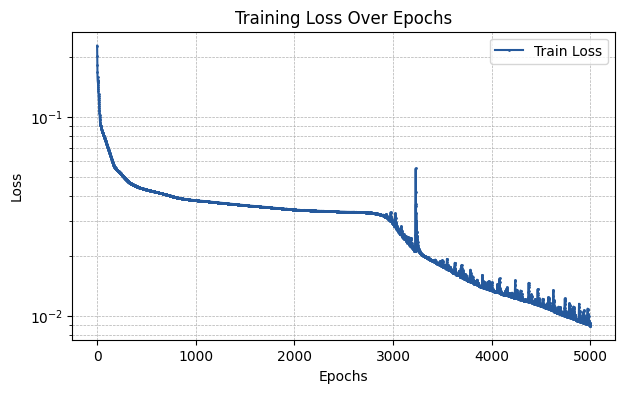

In [7]:
plt.figure(figsize=(7, 4))

plt.plot(np.array(train_losses), label='Train Loss', marker='o', color='#25599c', markersize=1)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.yscale('log')

plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5) 

plt.show()

The following plot shows the trained neural network on the entire domain, approximating the solution, $u$, of the equation.

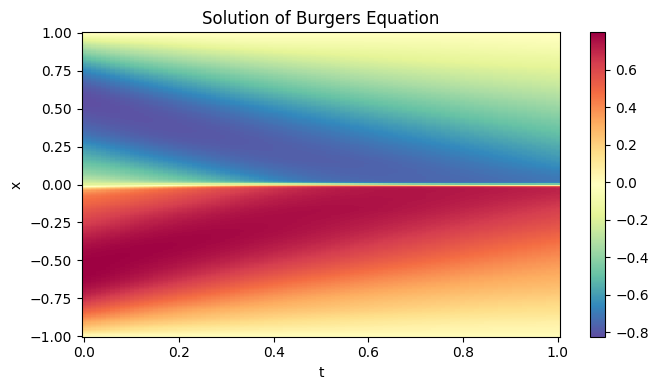

In [8]:
N_t, N_x = 100, 256

t = np.linspace(0.0, 1.0, N_t)
x = np.linspace(-1.0, 1.0, N_x)
T, X = np.meshgrid(t, x, indexing='ij')
coords = np.stack([T.flatten(), X.flatten()], axis=1)

output = model(jnp.array(coords))
resplot = np.array(output).reshape(N_t, N_x)

plt.figure(figsize=(7, 4))
plt.pcolormesh(T, X, resplot, shading='auto', cmap='Spectral_r')
plt.colorbar()

plt.title('Solution of Burgers Equation')
plt.xlabel('t')

plt.ylabel('x')

plt.tight_layout()
plt.show()